In [11]:
import json
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import psycopg2
from dotenv import dotenv_values
from locus.utils.paths import SQL_DIR


In [12]:
config = dotenv_values("../.env")
conn = psycopg2.connect(
    host=config["DB_HOST"],
    port=config["DB_PORT"],
    dbname=config["DB_NAME"],
    user=config["DB_USER"],
    password=config["DB_PASSWORD"],
)
cur = conn.cursor()

In [13]:
with open(SQL_DIR / "select_batch.sql", "r") as f:
    sql_string = f.read()

In [14]:
# function that times the execution of a function
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        ret = func(*args, **kwargs)
        print(f"{func.__name__} took {time.time() - start:.2f} seconds to fetch {args[0]} items")
        return ret, time.time() - start

    return wrapper

In [15]:
# timeit example
@timeit
def get_item_timer(n: int):
    rand_ids = [random.randint(0, 3993899) for _ in range(n)]
    sql_s = sql_string.format(f"({', '.join(map(str, rand_ids))})")
    results_df = pl.read_database(sql_s, conn)

get_item_timer(3)

get_item_timer took 0.02 seconds to fetch 3 items


(None, 0.02301621437072754)

In [16]:
def write_as_json(X, Y, Y_mean, Y_std, Y_avg_time):
    # stats into json file
    with open("results_datafetch_db.json", "w") as file:
        json.dump(
            {
                "X": X.tolist(),
                "Y": Y,
                "Y_mean": Y_mean,
                "Y_std": Y_std,
                "Y_avg_time": Y_avg_time,
            },
            file,
        )

In [17]:
# x should be a logarithmix linspace from 1 to 5000
X = np.logspace(0, np.log10(2000.5), 20, dtype=np.int64)
# X = np.logspace(0, 0.8, 3, dtype=np.int64)

# x remove duplicates
X = np.unique(X)

Y = []
Y_mean = []
Y_std = []
Y_avg_time = []
for x in X:
    y = []
    for i in range(5):
        _, t = get_item_timer(x)
        y.append(t)

    Y.append(y)
    Y_mean.append(np.mean(y))
    Y_std.append(np.std(y))
    Y_avg_time.append(np.mean(y) / x)

    write_as_json(X, Y, Y_mean, Y_std, Y_avg_time)

get_item_timer took 0.01 seconds to fetch 1 items
get_item_timer took 0.00 seconds to fetch 1 items
get_item_timer took 0.00 seconds to fetch 1 items
get_item_timer took 0.00 seconds to fetch 1 items
get_item_timer took 0.00 seconds to fetch 1 items
get_item_timer took 0.00 seconds to fetch 2 items
get_item_timer took 0.00 seconds to fetch 2 items
get_item_timer took 0.00 seconds to fetch 2 items
get_item_timer took 0.00 seconds to fetch 2 items
get_item_timer took 0.00 seconds to fetch 2 items
get_item_timer took 0.00 seconds to fetch 3 items
get_item_timer took 0.00 seconds to fetch 3 items
get_item_timer took 0.00 seconds to fetch 3 items
get_item_timer took 0.00 seconds to fetch 3 items
get_item_timer took 0.00 seconds to fetch 3 items
get_item_timer took 0.00 seconds to fetch 4 items
get_item_timer took 0.00 seconds to fetch 4 items
get_item_timer took 0.00 seconds to fetch 4 items
get_item_timer took 0.00 seconds to fetch 4 items
get_item_timer took 0.00 seconds to fetch 4 items


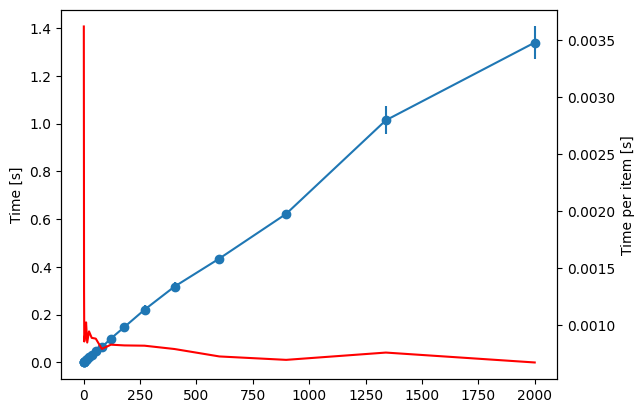

In [18]:
fig, ax1 = plt.subplots()

# Plot error bar on first axis
ax1.errorbar(X, Y_mean, Y_std, fmt='-o')
ax1.set_ylabel('Time [s]')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

# Create second axis
ax2 = ax1.twinx()

# Plot line chart on second axis
ax2.plot(X, Y_avg_time, color='r')
ax2.set_ylabel('Time per item [s]')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()